In [14]:
import pickle
import re
import numpy as np
import pandas as pd
import random
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import tqdm
import joblib
import os
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from modules.function import PTR, image_gfa, special_formatting, check_cuda
from modules.encoder import Encoder

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
random.seed(0)
torch.manual_seed(0)

In [4]:
gfa_dataset_file = 'gfa_dataset.txt'
z_row_column_file = 'Z_row_column.txt'
element_property_file = 'element_property.txt'
common_path = "Files_from_GTDL_paper/{}" 
gfa_dataset = pickle.load(open(common_path.format(gfa_dataset_file), 'rb'))  
RC = pickle.load(open(common_path.format(z_row_column_file), 'rb')) 
new_index=[int(i[4]) for i in RC]#new order 
Z_row_column = pickle.load(open(common_path.format(z_row_column_file), 'rb'))
[property_name_list,property_list,element_name,_]=pickle.load(open(common_path.format(element_property_file), 'rb'))

In [5]:
gfa_i=[]
gfa_a=[]
gfa_b=[]
gfa_c=[]
for i in  gfa_dataset:
    tx_gfa=re.findall('\[[a-c]?\]', i)#[B, Fe, P,No]
    gfa_i.extend(tx_gfa)
    if tx_gfa[0]=='[a]':
        gfa_a.append(gfa_dataset.index(i))
    elif tx_gfa[0]=='[b]':
        gfa_b.append(gfa_dataset.index(i)) 
    else:
        gfa_c.append(gfa_dataset.index(i))
        
gfa_data_form=[]
gfa_data_form_b=[]
#------------------------------------------------------------------------------
#map raw data to 2-D image using PTR
for i in gfa_a:
    x,y = PTR(gfa_dataset[i],property_list, element_name,Z_row_column)
    gfa_data_form=gfa_data_form+x
    gfa_data_form_b=gfa_data_form_b+y
for i in gfa_c:
    x,y = PTR(gfa_dataset[i],property_list, element_name,Z_row_column)
    gfa_data_form=gfa_data_form+x
    gfa_data_form_b=gfa_data_form_b+y 
for i in gfa_b:
    x,y = PTR(gfa_dataset[i],property_list, element_name,Z_row_column)
    gfa_data_form=gfa_data_form+[x[0]]
    gfa_data_form_b=gfa_data_form_b+[y[0]]  

X_all = np.array(gfa_data_form).reshape(-1, 1,9, 18).astype('float32') 
y_all = np.array(gfa_data_form_b).reshape(-1,1).astype('float32')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.20,random_state = 0)
batch = 64
Xy = [(X_train[i],y_train[i]) for i in range(len(y_train))]
train_loader = DataLoader(Xy, batch_size = batch , shuffle=True)

In [7]:
gfa_Encoder = Encoder(1,1)
e_optimizer = optim.Adam(gfa_Encoder.parameters(),lr = 1e-3)

In [8]:
num_iterations = 2000
cuda = check_cuda()
if cuda:
  gfa_Encoder = gfa_Encoder.cuda()
log_interval = int(5e1)
for iter in tqdm.notebook.tqdm(range(num_iterations)):
  train_loss = 0.0
  for data in train_loader:
    X,y = data
    if cuda:
      X = X.cuda()
      y = y.cuda()
    e_optimizer.zero_grad()
    target = gfa_Encoder(X)
    if cuda:
      target = target.cuda()
    e_error = torch.nn.BCELoss()(target,y)
    e_error.backward(retain_graph=True)
    e_optimizer.step()
    train_loss += e_error.cpu().item()
  if iter == 0 or (iter + 1) % log_interval == 0:  
    print('Epoch : {}, Loss : {}'.format(iter+1,train_loss))

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch : 1, Loss : 123.44415724277496
Epoch : 50, Loss : 37.903389632701874
Epoch : 100, Loss : 29.904005233198404
Epoch : 150, Loss : 27.137642059475183
Epoch : 200, Loss : 25.28517533838749
Epoch : 250, Loss : 22.734359480440617
Epoch : 300, Loss : 23.16416674107313
Epoch : 350, Loss : 21.585824821144342
Epoch : 400, Loss : 20.67875083349645
Epoch : 450, Loss : 19.797064126469195
Epoch : 500, Loss : 20.04247446358204
Epoch : 550, Loss : 21.442574568092823
Epoch : 600, Loss : 18.107055198401213
Epoch : 650, Loss : 18.24462049547583
Epoch : 700, Loss : 17.85005822777748
Epoch : 750, Loss : 16.584587091914727
Epoch : 800, Loss : 17.247497127042152
Epoch : 850, Loss : 18.707229901105165
Epoch : 900, Loss : 16.460101085714996
Epoch : 950, Loss : 16.243264745222405
Epoch : 1000, Loss : 15.60648980224505
Epoch : 1050, Loss : 15.752383912913501
Epoch : 1100, Loss : 14.845929754083045
Epoch : 1150, Loss : 15.181890428997576
Epoch : 1200, Loss : 14.693347927874129
Epoch : 1250, Loss : 14.678394

In [12]:
if X_test.dtype != torch.float32:
    X_test = torch.from_numpy(X_test)
if cuda:
    X_test =  X_test.cuda()
y_predict = (gfa_Encoder(X_test)).to('cpu').detach().numpy()
target_names = ['Crystalline','Amorphous']
clf = classification_report(y_test, np.round(y_predict), target_names=target_names,output_dict=True)

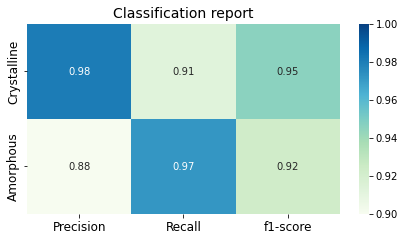

In [13]:
fig,ax = plt.subplots(figsize = (7,3.5))
ax = sns.heatmap(pd.DataFrame(clf).iloc[:-1, :2].T, annot=True, vmax=1,vmin=0.9,cmap = 'GnBu')
ax.set_yticklabels(labels = ['Crystalline','Amorphous'],fontsize=12)
ax.set_xticklabels(labels = ['Precision','Recall','f1-score'],fontsize=12)
plt.title('Classification report',fontsize=14)

saved_fig_path = 'figures'
if not os.path.exists(f'{saved_fig_path}'):
  os.makedirs(f'{saved_fig_path}')
plt.savefig(saved_fig_path+'/classification_report.pdf')

In [12]:
general_path = 'saved_models'
kind = 'PTR'
if not os.path.exists(f'{general_path}/{kind}'):
  os.makedirs(f'{general_path}/{kind}')
joblib.dump(gfa_Encoder,f'{general_path}/{kind}/PTR_Encoder.pt')

['saved_models/PTR/PTR_Encoder.pt']